#### New User Booking

##### Objective
    In this recruiting competition, Airbnb challenges you to predict in which country a new user will make his or her first booking.
    
##### Description
    In this challenge, you are given a list of users along with their demographics, web session records, and some summary statistics. You are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

##### 01.05
1. change submission format: submit 5 candidates for each id;
2. random forest tree
    - with no date info:
        * cross validation score: 0.7965
        * submission score: 0.84737
    - add date info: 
        * cross validation score: 0.5848
        * submission score: 0.83995
    - add month info:
        * cross validation score: 0.7515
        * submission score: 0.82841
3. XGBClassifier:
    - without date info:
        * cross validation score: 0.8230
        * submission score: 0.86590
    - with month info:
        * cross validation score: 0.8128
        * submission score: 0.8644
    - clean age data:
        * cross validation score: 0.82327
        * submission score: 0.86475 
    - make age int instead of string:
        * cv score: 0.823116988110146
        * sub score: 0.86533
    

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import pandas as pd

def handle_age(age):
    age = float(age)
    if age>0 and age<100:
        return int(age)/5
    elif age>=100 and age<150:
        return '100+'
    elif age >= 150:
        return 'unvalid'
    else:
        return 'NA'

def clean_data(data):
    data['age'] = data['age'].apply(handle_age)
#     dac = np.vstack(data.date_account_created.astype(str) \
#             .apply(lambda x: list(x.split('-'))).values)
#     data['dac_year'] = dac[:,0]
#     data['dac_month'] = dac[:,1]
#     data['dac_day'] = dac[:,2]
#     tfa = np.vstack(data.timestamp_first_active.astype(str) \
#             .apply(lambda x: list([x[:4],x[4:6],x[6:8]])).values)
#     data['tfa_year'] = tfa[:,0]
#     data['tfa_month'] = tfa[:,1]
#     data['tfa_day'] = tfa[:,2]
    data.set_index('id', inplace=True)
    return data.drop(['date_first_booking', 'timestamp_first_active', 'date_account_created'], axis=1) \
               .replace('-unknown-', 'NA').fillna('NA')

train_data = pd.read_csv('./train_users_2.csv')
train_data = clean_data(train_data)

test_data = pd.read_csv('./test_users.csv')
test_ids = test_data['id']
test_data = clean_data(test_data)

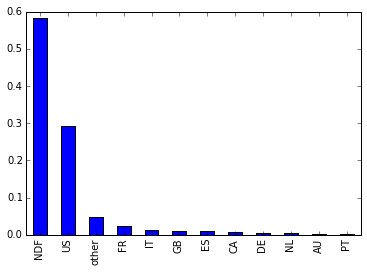

In [4]:
# view training data
#what % of users go to which country
#print train_data['country_destination'].tolist()
x = train_data.country_destination.value_counts() / len(train_data.country_destination)
x.plot(kind='bar')

In [5]:
session_data = pd.read_csv('./sessions.csv')

In [18]:
result = session_data.groupby(['user_id'])['device_type'].agg(lambda x:x.value_counts().index[0])

In [ ]:
train_data = train_data.merge(pd.DataFrame(result), how='left', left_index=True, right_index=True)
print train_data

In [6]:
result = pd.DataFrame(session_data.groupby(['user_id'])['secs_elapsed'].agg(lambda x:int(sum(x)/3600/24)))
train_data = train_data.merge(pd.DataFrame(result), how='left', left_index=True, right_index=True)
print train_data

            gender age signup_method  signup_flow language affiliate_channel  \
id                                                                             
gxn3p5htnn      NA  NA      facebook            0       en            direct   
820tgsjxq7    MALE   7      facebook            0       en               seo   
4ft3gnwmtx  FEMALE  11         basic            3       en            direct   
bjjt8pjhuk  FEMALE   8      facebook            0       en            direct   
87mebub9p4      NA   8         basic            0       en            direct   
osr2jwljor      NA  NA         basic            0       en             other   
lsw9q7uk0j  FEMALE   9         basic            0       en             other   
0d01nltbrs  FEMALE   9         basic            0       en            direct   
a1vcnhxeij  FEMALE  10         basic            0       en             other   
6uh8zyj2gn      NA   9         basic            0       en             other   
yuuqmid2rp  FEMALE   7         basic    

In [8]:
from sklearn import preprocessing
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
Y = train_data['country_destination']
X = train_data.drop('country_destination', axis=1)
X = vectorizer.fit_transform(X.T.to_dict().values())
test_X = vectorizer.transform(test_data.T.to_dict().values())
print len(test_X[0])
print len(X[0])
print vectorizer.feature_names_

137
137
['affiliate_channel=api', 'affiliate_channel=content', 'affiliate_channel=direct', 'affiliate_channel=other', 'affiliate_channel=remarketing', 'affiliate_channel=sem-brand', 'affiliate_channel=sem-non-brand', 'affiliate_channel=seo', 'affiliate_provider=baidu', 'affiliate_provider=bing', 'affiliate_provider=craigslist', 'affiliate_provider=daum', 'affiliate_provider=direct', 'affiliate_provider=email-marketing', 'affiliate_provider=facebook', 'affiliate_provider=facebook-open-graph', 'affiliate_provider=google', 'affiliate_provider=gsp', 'affiliate_provider=meetup', 'affiliate_provider=naver', 'affiliate_provider=other', 'affiliate_provider=padmapper', 'affiliate_provider=vast', 'affiliate_provider=wayn', 'affiliate_provider=yahoo', 'affiliate_provider=yandex', 'age', 'age=100+', 'age=NA', 'age=unvalid', 'first_affiliate_tracked=NA', 'first_affiliate_tracked=linked', 'first_affiliate_tracked=local ops', 'first_affiliate_tracked=marketing', 'first_affiliate_tracked=omg', 'first_

In [9]:
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation
import math
# rfc = RandomForestClassifier()
rfc = XGBClassifier()

def ndcg_scorer(estimator, X_test, y_test):
    dcgs = []
    y_test = y_test.tolist()
    pr = estimator.predict_proba(X_test)
    for i in range(len(y_test)):
        classes_ = np.array(estimator.classes_)
        pred_targets = classes_[np.argsort(pr[i])[::-1][:5]].tolist()
        true_target = y_test[i]
        try:
            idx = pred_targets.index(true_target)
            dcgs.append(1/(math.log(2+idx, 2)))
        except ValueError:
            dcgs.append(0)
            pass        
    return mean(dcgs)
    
cross_validation.cross_val_score(rfc, X, Y, cv=5, scoring=ndcg_scorer).mean()

0.80663839154265093

In [359]:
rfc.fit(X, Y)
pr = rfc.predict_proba(test_X)

In [360]:
cts = []
ids = []
classes_ = np.array(rfc.classes_)
for i in range(len(test_ids)):
    idx = test_ids[i]
    ids += [idx] * 5
    cts += classes_[np.argsort(pr[i])[::-1][:5]].tolist()
    
sub = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])
sub.to_csv('./submission.csv', index=False)